# [0] Loading data

In [1]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
DATA_DIR = "./dataset/rf_dataset_yolov11_with_mask/"

x_train_dir = os.path.join(DATA_DIR, "train", "images")
y_train_dir = os.path.join(DATA_DIR, "train", "masks")

x_valid_dir = os.path.join(DATA_DIR, "valid", "images")
y_valid_dir = os.path.join(DATA_DIR, "valid", "masks")

x_test_dir = os.path.join(DATA_DIR, "test", "images")
y_test_dir = os.path.join(DATA_DIR, "test", "masks")

## [1] Dataloader

In [3]:
import os
import cv2
import numpy as np
import albumentations as A

class CustomSegmentationDataset(Dataset):
    # !여기서는 CLASS 자체를 정의했는데, 우리 데이터는 색으로 지정을 해놨으니 없어도 되지 않나?
    CLASSES = [
        "Flower",
        "Immature_fruit",
        "Leaf",
        "Mature_fruit",
        "Stem",
        "unlabelled",
    ]

    # mask의 색상(RGB) -> 클래스 인덱스 매핑
    RGB_TO_CLASS = {
        (255, 0, 0): 1,         # Red: Flower
        (0, 255, 0): 2,         # Green: Immature_fruit
        (0, 0, 255): 3,         # Blue: Leaf
        (255, 255, 0): 4,       # Yellow: Mature_fruit
        (255, 0, 255): 5,       # Pink: Stem
        (0, 0, 0): 0            # Black: default(background)
    }

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        """
        Args:
            images_dir (str): 원본 이미지가 저장된 디렉토리 경로
            masks_dir (str): 컬러 마스크 이미지가 저장된 디렉토리 경로
            classes (list, optional): 관심 있는 클래스명 리스트 (지정하지 않으면 전체 클래스 사용)
            augmentation (albumentations.Compose, optional): augmentation pipeline
            preprocessing (albumentations.Compose, optional): 전처리 pipeline
        """
        # 이미지 파일 아이디(파일명)를 기준으로 파일 경로를 구성
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[:-4]+"_mask.png") for image_id in self.ids]     # mask 파일명 형식에 맞춰 수정

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def convert_mask(self, mask):
        """
        RGB mask (H, W, 3)을 받아서 각 픽셀의 색상에 따라 단일 채널 label mask (H, W)를 생성하는 함수.
        """
        height, width, _ = mask.shape
        mask_remap = np.zeros((height, width), dtype=np.uint8)

        # 각 지정된 색상에 대해 해당 픽셀에 클래스 인덱스 할당
        for rgb, cls in self.RGB_TO_CLASS.items():
            # np.all(mask == np.array(rgb), axis=-1)을 통해 해당 색상의 픽셀 위치 (H, W)를 구함
            matches = np.all(mask == np.array(rgb), axis=-1)
            mask_remap[matches] = cls

        return mask_remap

    def __getitem__(self, idx):
        # 원본 이미지 읽기 및 BGR -> RGB 변환 (cv2는 기본적으로 BGR을 읽음)
        image = cv2.imread(self.images_fps[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # mask 이미지도 컬러로 읽은 후, BGR -> RGB 변환
        mask = cv2.imread(self.masks_fps[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # 변환 함수(convert_mask)로 컬러 mask를 단일 채널 label mask로 변환
        mask_np = np.array(mask)
        mask_remap = self.convert_mask(mask_np)

        # augmentation 적용 (e.g. 좌우 반전, 회전 등)
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask_remap)
            image, mask_remap = augmented["image"], augmented["mask"]

        # preprocess 적용 (e.g. 정규화, 리사이즈 등)
        # !목적에 따라 다를 순 있겠으나, Augmentation->preprocessing 순서가 합리적인 거 같다(증강은 원본 이미지를 기준으로 되어야 할 듯 싶다)
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask_remap)
            image, mask_remap = preprocessed['image'], preprocessed['mask']

        # torch 모델 입력을 위한 이미지 차원 변환 (H, W, C) -> (C, H, W)
        image = image.transpose(2, 0, 1)

        return image, mask_remap

    def __len__(self):
        return len(self.ids)

/home/leedh/bin/miniconda3/envs/k-melon_seg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


왜 동일한 albumentations를 사용하는데 preprocessing/argumentation을 구분했는가?
- Preprocessing: 데이터를 모델의 입력 형식에 맞게 변환하는 과정
- Augmentation: 모델의 일반화 성능을 높이기 위해 데이터를 변형하는 과정<br>
> Preprocessing은 train/valid/test 모든 데이터에 적용되는 반면, Augmentation은 train에만 적용된다.<br>
> 이 둘을 분리함으로써 코드 유지보수가 쉬워지고 두 단계를 독립적으로 관리할 수 있다.

In [4]:
def visualize(**images):
    """Plot images in one row"""
    n = len(images)
    plt.figure(figsize=(12, 6))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split('_')).title())

        # 이미지면 RGB 출력
        if name == "image":
            image = image.transpose(1, 2, 0)    # 채널 순서를 CHW에서서 HWC로 변환
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='tab20')

    plt.show()

Image shape: (3, 640, 640), Mask shape: (640, 640)


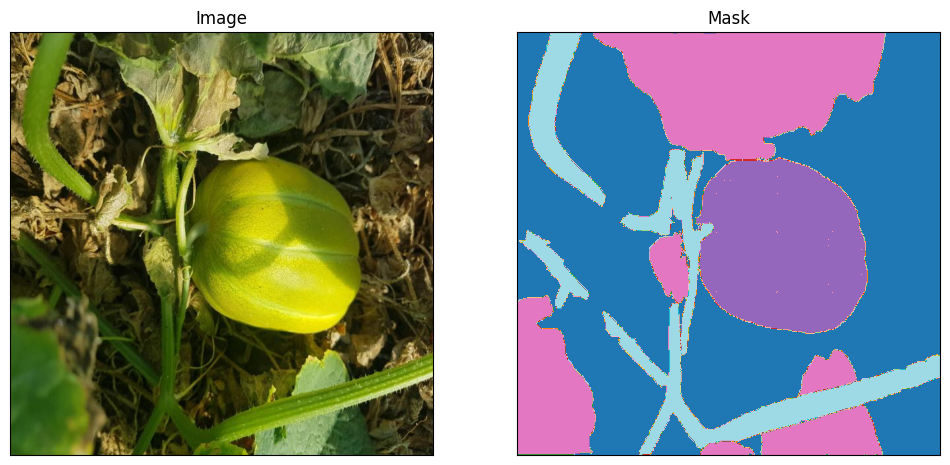

In [5]:
dataset = CustomSegmentationDataset(x_train_dir, y_train_dir)
image, mask = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
visualize(image=image, mask=mask)

# [2] Augmentations

In [6]:
# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),    # 좌우반전
        A.Affine(         # Affine 변환 - 확대축소(scale)/회전(rotate)/이동(shift)
            scale=0.9, rotate=10, translate_percent=0.1, p=0.5, border_mode=0   # border_mode: 이미지 경계 처리 방법 (e.g. cv2.BORDER_CONSTANT: 빈 공간을 채움)
        ),
        A.PadIfNeeded(min_height=640, min_width=640, p=1),    # 이미지가 지정된 최소 크기보다 작으면 패딩(padding)을 추가하여 크기를 맞춤
        A.RandomCrop(height=512, width=512, p=0.5),     # 지정된 크기만큼 crop
        A.GaussNoise(p=0.1),        # 가우시안 노이즈 추가(노이즈가 있는 데이터에 강건한 모델을 학습하도록 함)
        A.Perspective(p=0.5),       # 원근 변환 적용(다양한 시점에서 촬영된 데이터를 학습할 수 있도록 함)
        A.OneOf(    # OneOf: 여러 증강 기법 중 하나를 랜덤하게 선택하여 적용 -> brightness/contrast/colors manipulations
            [
                A.CLAHE(p=1),                       # 히스토그램 균등화
                A.RandomBrightnessContrast(p=1),    # 밝기/대비 조정
                A.RandomGamma(p=1),                 # 감마 조정
            ],
            p=0.9,      # 선택된 증강 기법이 적용될 확률
        ),
        A.OneOf(    # image bluring and sharpening
            [
                A.Sharpen(p=1),                     # 샤프닝
                A.Blur(blur_limit=3, p=1),          # 블러링
                A.MotionBlur(blur_limit=3, p=1),    # 모션 블러링
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),    # 밝기/대비 조정
                A.HueSaturationValue(p=1),          # 색도/채도 변경
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(512, 512),
    ]
    return A.Compose(test_transform)

# images preprocessing
def get_preprocessing():
    img_preprocessing = [
        A.Resize(height=512, width=512)     # 크기 조정
        # 정규화
        # ToTensor
        # 등등
    ]
    return A.Compose(img_preprocessing)

Mask shape: (512, 512)
[0 2 3 5]


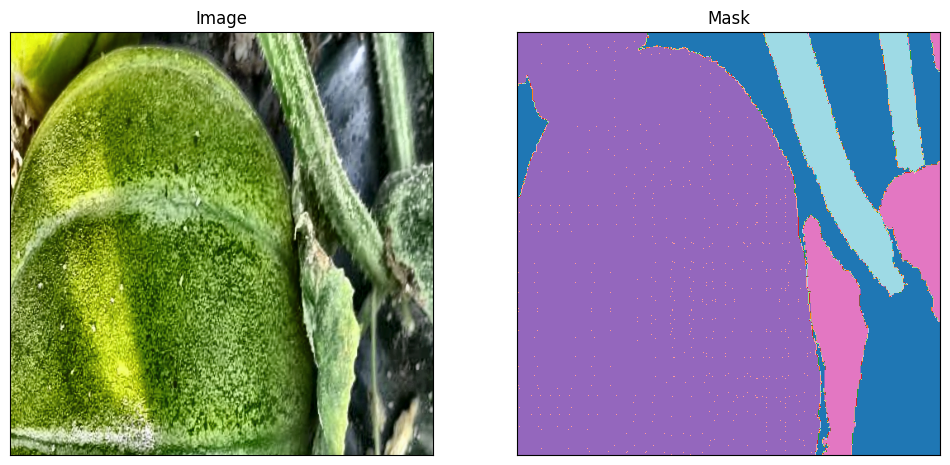

Mask shape: (512, 512)
[0 2 3 5]


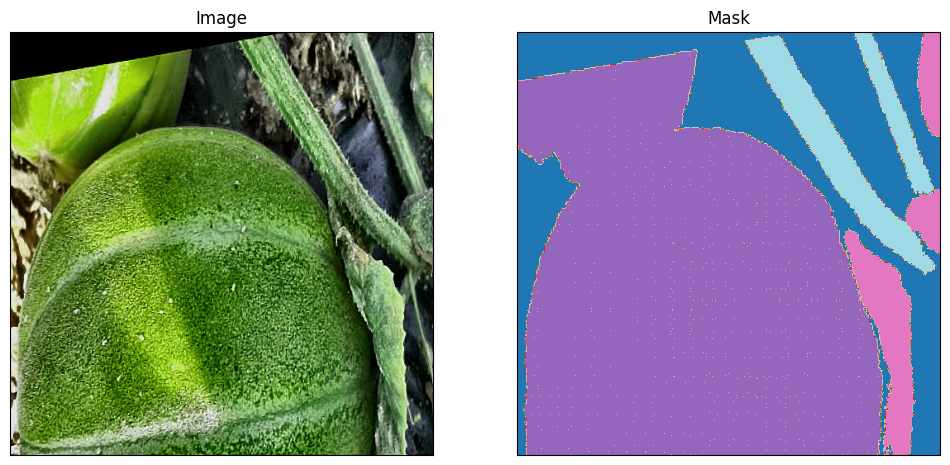

Mask shape: (512, 512)
[0 2 3 5]


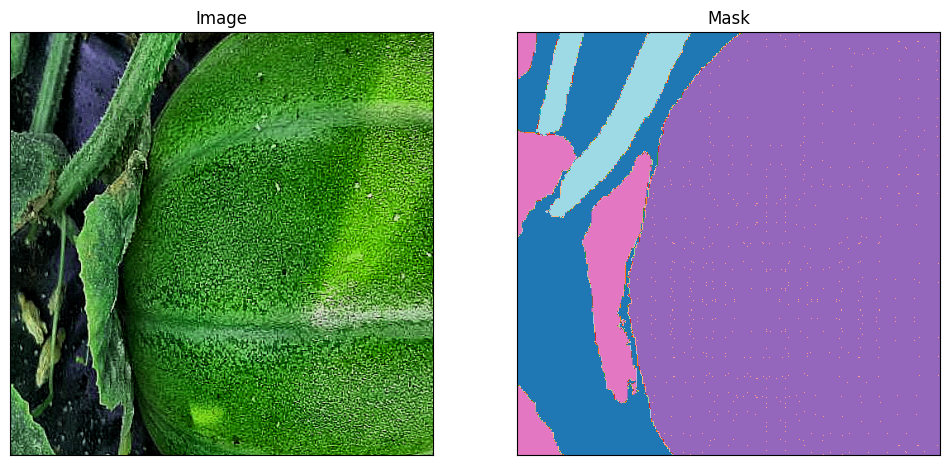

In [7]:
# augmented images and masks 시각화(잘 적용되나 확인)
augmented_dataset = CustomSegmentationDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(),
)

# 동일한 이미지에 여러 증강 적용
for i in range(3):
    image, mask = augmented_dataset[3]
    print(f"Mask shape: {mask.shape}")
    print(np.unique(mask))      # mask 이미지의 고유한 class 확인
    visualize(image=image, mask=mask)

In [8]:
# 각각의 데이터로더 생성
train_dataset = CustomSegmentationDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(),
)

valid_dataset = CustomSegmentationDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
)

test_dataset = CustomSegmentationDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

# [3] Create model and train

In [9]:
# training hyperparameters
EPOCHS = 50
T_MAX = EPOCHS * len(train_loader)      # 학습 과정에서 사용할 총 스텝(step) 수    e.g. dataset=1000, batch=10 -> len(train_loader)=100, EPOCH=50 -> T_MAX=5000
# T_MAX는 학습률 스케줄러에서 사용되곤 한다(일부 스케줄러는 전체 학습 스텝 수를 기준으로 학습률을 점진적으로 감소)

# Always include the background as a class
OUT_CLASSES = len(train_dataset.CLASSES)    # 모델의 출력 채널 수 정의

In [10]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.optim import lr_scheduler


class TempModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(      # smp 라이브러리를 사용해 지정된 아키텍처와 백본으로 모델 생성
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))           # register buffer는 학습 중 업데이트 되지 않는 값을 저장할 때 사용
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)    # Dice 손실 함수를 사용하여 segmentation 성능 평가

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):        # 학습/검증/테스트 단계에서 공통적으로 사용하는 로직을 정의
        image, mask = batch

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, channels, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):     # epoch 종료 시 메트릭 계산(epoch가 끝날 때 호출되며 IoU와 같은 메트릭을 계산)
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    # 학습/검증/테스트 단계
    def training_step(self, batch, batch_idx):          # 학습 배치 데이터를 처리하고 손실 및 통계값 반환
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):        # 검증 배치 데이터를 처리하고 손실 및 통계값 반환
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):              # 테스트 배치 데이터를 처리하고 손실 및 통계값 반환
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):         # 옵티마이저와 스케줄러 설정
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [11]:
model = TempModel("DeepLabV3Plus", "mobilenet_v2", in_channels=3, out_classes=OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/leedh/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 24.9MB/s]


# Training

In [12]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/leedh/bin/miniconda3/envs/k-melon_seg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/leedh/bin/miniconda3/envs/k-melon_seg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s]

/home/leedh/bin/miniconda3/envs/k-melon_seg/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


/home/leedh/bin/miniconda3/envs/k-melon_seg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s, v_num=1, valid_per_image_iou=0.837, valid_dataset_iou=0.831, train_per_image_iou=0.801, train_dataset_iou=0.790]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s, v_num=1, valid_per_image_iou=0.837, valid_dataset_iou=0.831, train_per_image_iou=0.801, train_dataset_iou=0.790]


# Validation and test metrics

In [13]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 14/14 [00:03<00:00,  4.05it/s]
[{'valid_per_image_iou': 0.8367526531219482, 'valid_dataset_iou': 0.8310513496398926}]


In [14]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/leedh/bin/miniconda3/envs/k-melon_seg/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 14/14 [00:03<00:00,  3.98it/s]
[{'test_per_image_iou': 0.8583887815475464, 'test_dataset_iou': 0.854986310005188}]


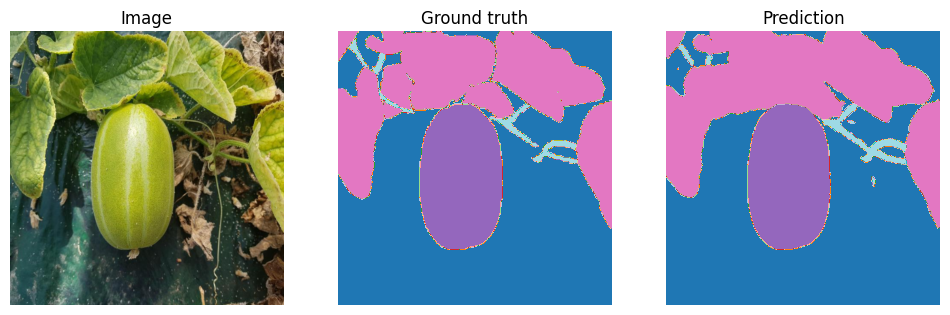

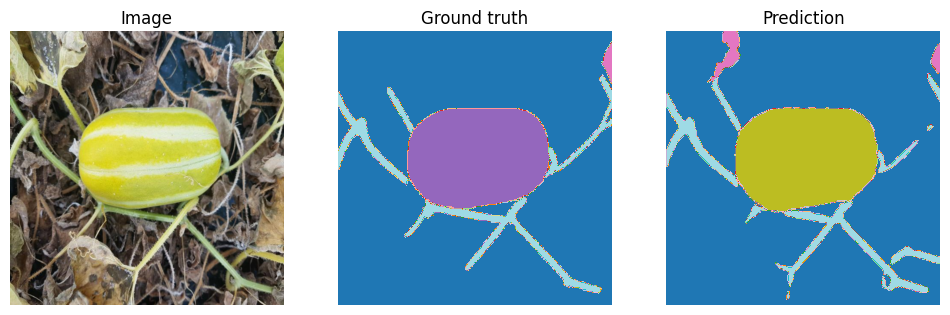

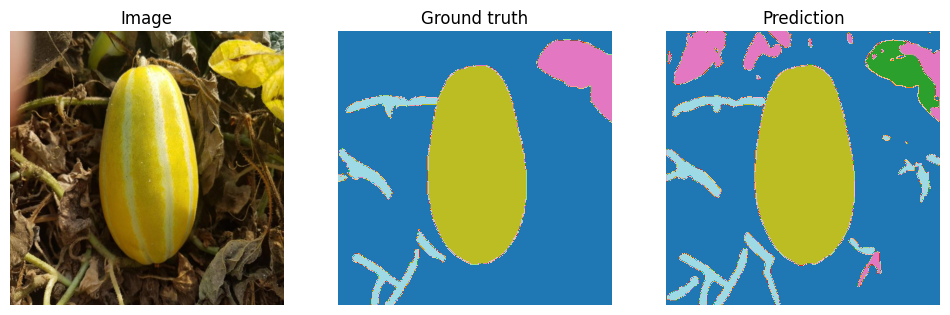

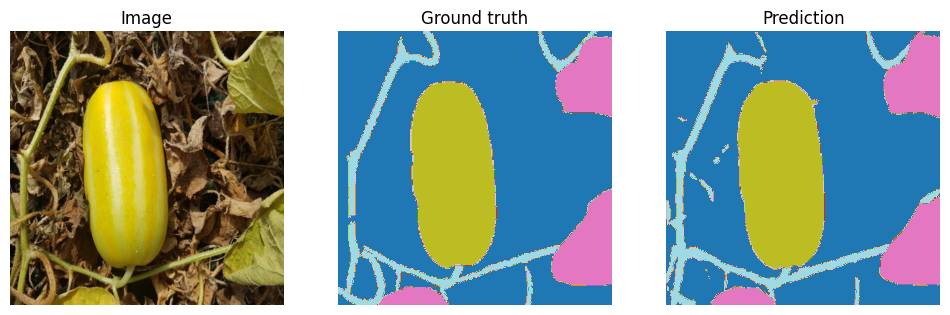

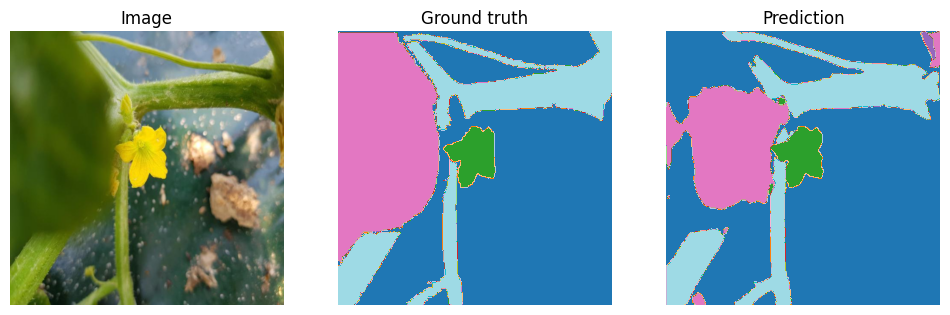

In [18]:
import numpy as np

# Fetch a batch from the test loader
images, masks = next(iter(test_loader))

# Switch the model to evaluation mode
with torch.no_grad():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break